In [78]:
# Import plotly and pandas
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [79]:
df = pd.read_csv('/Users/newuser/Projects/robust-algo-trader/data/EURUSD/EURUSD_H1_200702210000_202304242100.csv')

In [80]:
df

,Unnamed: 0,Open,High,Low,Close,Volume,Date_Time,SMA_20,SMA_30,SMA_50,...,STOCH_K,STOCH_D,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI
0,199,1.31170,1.31190,1.30840,1.30950,583,2007.03.05 12:00:00,1.315585,1.315907,1.317010,...,13.212454,14.167962,-91.269841,1.315508,1.312280,1.309052,-2.608051e+03,-509.905307,55.222567,22.935110
1,200,1.30960,1.31040,1.30810,1.30850,364,2007.03.05 13:00:00,1.315165,1.315623,1.316750,...,7.757055,10.759067,-96.899225,1.314926,1.311160,1.307394,-2.845442e+03,-562.879596,48.156152,22.010781
2,201,1.30860,1.30950,1.30740,1.30830,536,2007.03.05 14:00:00,1.314685,1.315337,1.316476,...,11.731414,10.900308,-92.436975,1.314176,1.310260,1.306344,-2.922013e+03,-557.743660,53.219275,15.875641
3,202,1.30860,1.30990,1.30700,1.30950,550,2007.03.05 15:00:00,1.314215,1.315070,1.316228,...,19.720832,13.069767,-76.190476,1.311821,1.309480,1.307139,-2.523737e+03,-378.214488,53.616348,24.223715
4,203,1.30960,1.31150,1.30960,1.30970,593,2007.03.05 16:00:00,1.313720,1.314843,1.315974,...,36.210245,22.554164,-73.786408,1.310259,1.309100,1.307941,-3.054316e+03,-439.208175,54.883033,32.794015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99971,100170,1.10237,1.10370,1.10207,1.10294,4538,2023.04.24 17:00:00,1.099604,1.098824,1.097905,...,84.062477,82.909956,-10.689170,1.103770,1.101910,1.100050,-3.906272e+06,1882.860989,61.854336,75.462298
99972,100171,1.10294,1.10323,1.10206,1.10260,3226,2023.04.24 18:00:00,1.099783,1.099061,1.098012,...,75.925112,79.894754,-15.471167,1.104009,1.102100,1.100191,-3.906520e+06,1669.983383,53.062106,72.423007
99973,100172,1.10260,1.10342,1.10249,1.10340,1878,2023.04.24 19:00:00,1.100006,1.099290,1.098121,...,80.981586,80.323058,-4.219409,1.103525,1.102732,1.101939,-3.904723e+06,2002.924994,45.850763,76.811778
99974,100173,1.10341,1.10484,1.10336,1.10441,1730,2023.04.24 20:00:00,1.100292,1.099499,1.098270,...,83.616879,80.174526,-5.212121,1.104581,1.103150,1.101719,-3.903998e+06,2187.640112,45.125640,79.921980


In [81]:
# First 30 rows
df = df.head(24 * 7 )

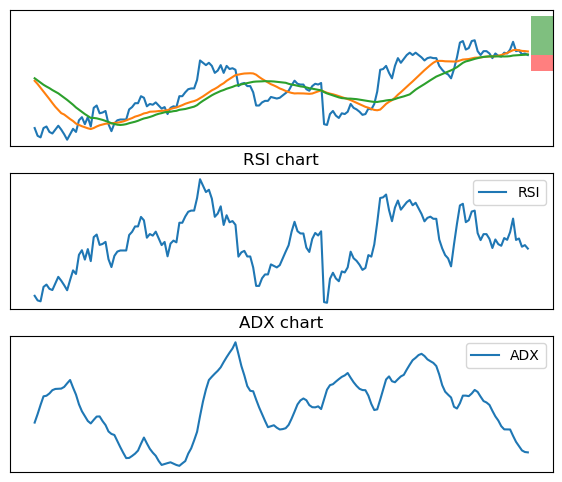

In [91]:
# Plot the price chart with Impulse MACD and its signal line
plt.figure(figsize=(7,6))
plt.subplot(3, 1, 1) # Create a subplot for the price chart
plt.plot(df["Close"], label="Close")
plt.plot(df["SMA_20"], label="SMA_20") # Add this line to plot the SMA_20 column
plt.plot(df["SMA_30"], label="SMA_50")
long_price = df["Close"].iloc[-1] # Get the close price of the last row
plt.axhspan(long_price, long_price + 0.005, facecolor="green", xmin= 0.96,  alpha=0.5) 
plt.axhspan(long_price - 0.002, long_price, facecolor="red", xmin= 0.96,  alpha=0.5) 
plt.xticks([])
plt.yticks([])

plt.subplot(3, 1, 2) 
plt.plot(df["RSI"], label="RSI")
# plt.axhline(70, color="red", linestyle="--") 
# plt.axhline(30, color="green", linestyle="--")
plt.legend()
plt.title("RSI chart")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

# Plot the ADX graph at the bottom of the plot
plt.subplot(3, 1, 3)
plt.plot(df["ADX"], label="ADX")
plt.legend()
plt.title("ADX chart")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()